In [54]:
import numpy as np
import pandas as pd

In [55]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [56]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [57]:
insurance['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [58]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

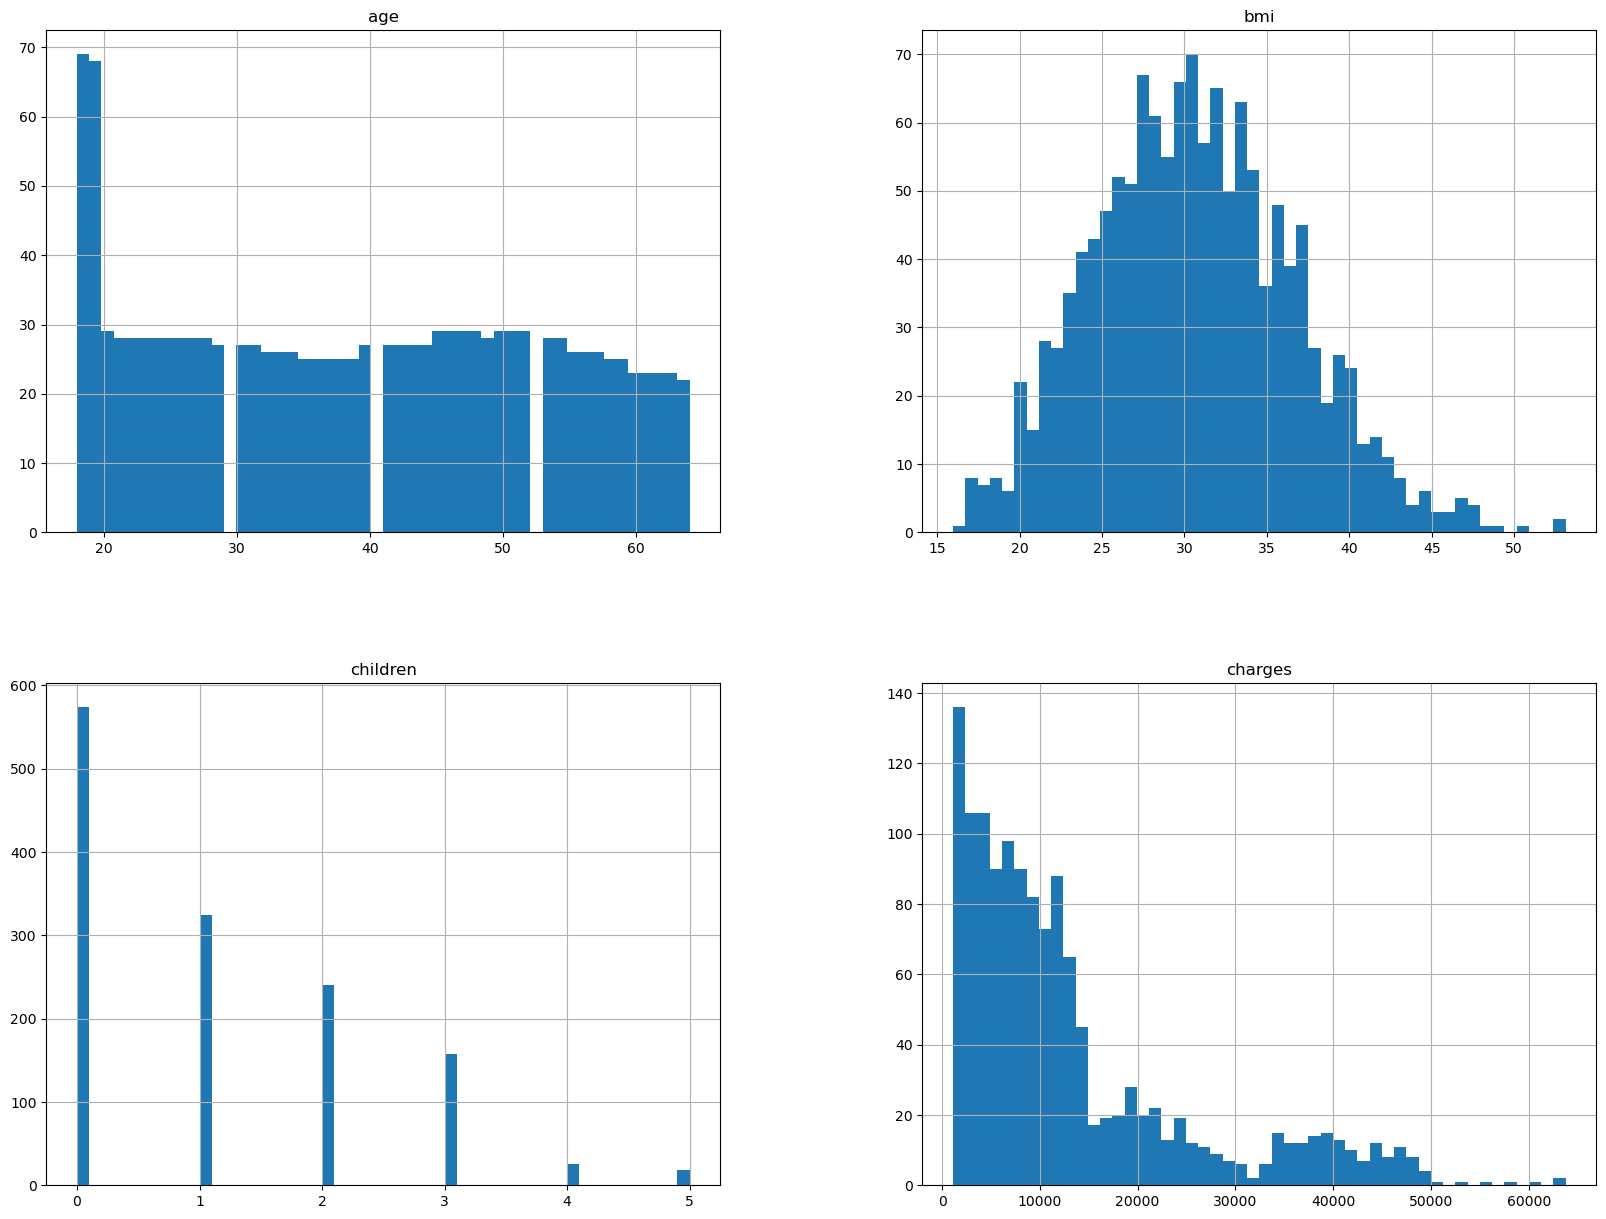

In [59]:
import matplotlib.pyplot as plt

insurance.hist(bins=50, figsize=(20,15))

In [60]:
insurance['age_group'] = np.floor(insurance["age"]/10)
insurance

,age,sex,bmi,children,smoker,region,charges,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,1.0
1,18,male,33.770,1,no,southeast,1725.55230,1.0
2,28,male,33.000,3,no,southeast,4449.46200,2.0
3,33,male,22.705,0,no,northwest,21984.47061,3.0
4,32,male,28.880,0,no,northwest,3866.85520,3.0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,5.0
1334,18,female,31.920,0,no,northeast,2205.98080,1.0
1335,18,female,36.850,0,no,southeast,1629.83350,1.0
1336,21,female,25.800,0,no,southwest,2007.94500,2.0


In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(insurance, insurance["age_group"]):
    strat_train_set = insurance.loc[train_index]
    strat_test_set = insurance.loc[test_index]

In [62]:
insurance["age_group"].value_counts()/len(insurance)

age_group
2.0    0.209268
4.0    0.208520
5.0    0.202541
3.0    0.192078
1.0    0.102392
6.0    0.085202
Name: count, dtype: float64

In [63]:
insurance = strat_train_set.copy()
insurance_labels = strat_train_set["charges"].copy()
corr_matrix = insurance.corr(numeric_only=True)
corr_matrix["charges"].sort_values(ascending=False)

charges      1.000000
age_group    0.300234
age          0.295954
bmi          0.195578
children     0.065674
Name: charges, dtype: float64

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
num_attribs = ['bmi']
cat_attribs = list(insurance.drop(['age', 'bmi'], axis=1))

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])


In [65]:
insurance_prepared = full_pipeline.fit_transform(insurance)
insurance_prepared

C:\Users\thoma\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.96949249,  1.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.28512653,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.98621247,  1.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.16250686,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03182845,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.90469045,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [66]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression()

In [67]:
some_data = insurance.iloc[:5]
some_labels = insurance_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t', lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [21880.82    40419.0191   8671.19125  8596.8278   8017.06115]
Labels:		 [21880.82, 40419.0191, 8671.19125, 8596.8278, 8017.06115]


In [68]:
from sklearn.metrics import mean_squared_error
insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.072827448769359e-11

In [69]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [70]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6055.82080882 4751.86831494 6852.89161414 6408.85071535 7656.53419138
 5054.94101058 5051.9339178  5786.9533795  6979.55376531 5463.06984945]
Mean: 6006.2417567273005
Standard deviation: 910.1879931496


In [71]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor()

In [72]:
insurance_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [73]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(insurance_prepared, insurance_labels)

RandomForestRegressor()

In [74]:
insurance_predictions = forest_reg.predict(insurance_prepared)
forest_mse = mean_squared_error(insurance_labels, insurance_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1728.1555624126527

In [75]:
forest_scores = cross_val_score(forest_reg, insurance_prepared, insurance_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5084.3027223  2835.42050977 5700.42536054 5841.27368524 5892.84153597
 2685.86561524 3675.89890076 3679.2547003  5492.41049181 3174.65329991]
Mean: 4406.234682183871
Standard deviation: 1248.5844138869109


In [91]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [50, 100, 150, 200], 'max_features': [2, 4, 6, 8, 10, 20]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(insurance_prepared, insurance_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 20],
                          'n_estimators': [50, 100, 150, 200]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [92]:
grid_search.best_params_

{'max_features': 20, 'n_estimators': 200}

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

6524.921860925932 {'max_features': 2, 'n_estimators': 50}
6323.040358118781 {'max_features': 2, 'n_estimators': 100}
6342.494316422804 {'max_features': 2, 'n_estimators': 150}
6190.495250958626 {'max_features': 2, 'n_estimators': 200}
6291.098393875741 {'max_features': 4, 'n_estimators': 50}
6132.324943045473 {'max_features': 4, 'n_estimators': 100}
6226.31896151012 {'max_features': 4, 'n_estimators': 150}
6070.062228319535 {'max_features': 4, 'n_estimators': 200}
6138.378458695089 {'max_features': 6, 'n_estimators': 50}
6019.514813783237 {'max_features': 6, 'n_estimators': 100}
6086.635966964567 {'max_features': 6, 'n_estimators': 150}
6112.605084582017 {'max_features': 6, 'n_estimators': 200}
6071.978034536997 {'max_features': 8, 'n_estimators': 50}
6063.59687592841 {'max_features': 8, 'n_estimators': 100}
6034.866987118991 {'max_features': 8, 'n_estimators': 150}
6068.6618915369245 {'max_features': 8, 'n_estimators': 200}
6059.258649691278 {'max_features': 10, 'n_estimators': 50}
59